# Setup: import data

In [116]:
import pandas as pd

df = pd.read_parquet('posts.parquet')
print(f'Loaded {len(df)} posts')
df.head(n=10)

# Columns in this dataframe:
# 
#     id:        Reddit post ID on reddit. The post itself can be viewed at
#                https://reddit.com/r/pokemontrades/comments/{id}
#     title:     Post title.
#     body:      Post body (in Markdown format).
#     submitter: The username of the submitter
#     time:      Post submission time, in UTC
#     flair:     Post flair (at the time the post was scraped)
#     hit:       Whether ApriBot's crude detection mechanism (keyword-search) thought the post was Aprimon-related.
#     vote:      /r/BankBallExchange's judgment as to whether the post was Aprimon-related. This is the ground truth.

Loaded 5792 posts


,id,title,body,submitter,time,flair,hit,vote
0,13gxmuw,LF: Drilbur and Solosis FT: Ask,Hello! Im currently in the process of breeding...,Dracon715,2023-05-14 00:35:25,SMUSUM,True,False
1,13gx0eg,"LF: 6IV Non-English Ditto FT: Apriballs, Abili...",I’ve got pretty much everything aside from ✨ m...,MistaKleen,2023-05-14 00:07:42,SV,True,False
2,13gwnha,"LF H-Zoroark and Flabebe Codes, Jiseok Lee Gar...",Also open to other event offers!\n\n\_\_\_\_\_...,ShaikhAndBake,2023-05-13 23:51:47,Event,False,False
3,13gw0vt,"LF: Apriball Stonjourner, Yamask, Honedge, HA ...","Hi! I'm looking for a Stonjourner, Yamask, Hon...",Rainy_Days1115,2023-05-13 23:24:22,SWSH,True,True
4,13gw04b,LF: Sobble. FT: scarlet exclusives/raid exclusive,"It's the only raid exclusive that I'm missing,...",gertygaming,2023-05-13 23:23:23,SV (Closed),False,False
5,13gvv1y,LF: Apriball Chespin FT: Other Apriball Chespin,Still need Chespin in the following balls (HA ...,RevolutioFalco,2023-05-13 23:17:05,SV,True,True
6,13gvr1f,"LF Moon Ball Hisuian Zorua, Heavy Ball Rookide...",Breedjects acceptable for all!\n\nEdit: Just r...,foozeld,2023-05-13 23:12:12,SV,True,True
7,13gux1l,LF: Low level Oshawott and Rowlett for PLA pla...,,clee8017,2023-05-13 22:36:33,PLA,True,False
8,13guog4,LF: cyndaquil FT: froakie??,i missed typhlosian and really want a cyndaqui...,uglycynda,2023-05-13 22:26:37,SV (Closed),False,False
9,13gucgy,"[SV] FT: Aprishinies, Shinies LF: Apriballs","FT (all shinies, all untouched):\n\n|Pokemon|B...",Only_Television2030,2023-05-13 22:13:07,Shiny,True,False


# How accurate was the original detection mechanism?

To visualise this, we can plot what's known as a *confusion matrix*, where each row corresponds to what the post *should* have been identified as, and each column corresponds to what the post was actually classified as.

The top-left and bottom-right entries, where the predicted and actual classes match each other, are the cases where the prediction was successful.

The bottom-left entry contains *false negatives*: posts which really were about Aprimon but weren't picked up on. It's reassuring that there aren't many of these!

The top-right entry contains *false positives*: posts which didn't really have Aprimon, but were still picked up. There are lots of these! This isn't really surprising, because I designed the keyword search to be very permissive, the rationale being that we'd rather get extra notifications about unwanted posts than miss out on posts we were genuinely interested in.

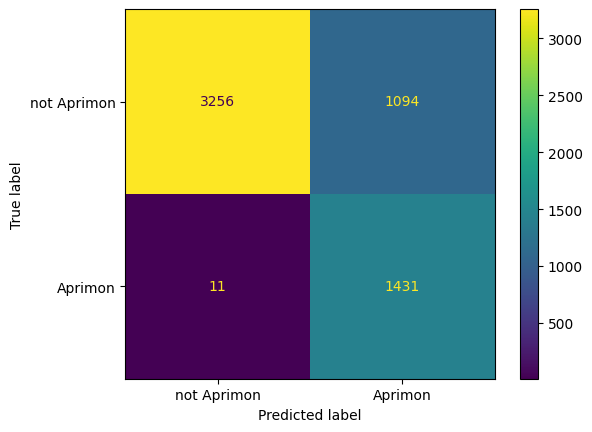

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=df.vote, y_pred=df.hit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not Aprimon', 'Aprimon'])
disp.plot()
plt.show()

We can extract some metrics from this:

 - *Accuracy*: the proportion of posts that were overall correctly categorised
 - *Sensitivity*: the proportion of Aprimon posts that were correctly picked up
 - *Specificity*: the proportion of non-Aprimon posts that were correctly ignored (we expect this to be not amazing)

In [118]:
def get_metrics(y_true, y_pred):
    "Returns accuracy, sensitivity, and specificity (in that order)."
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    true_pos = cm[1, 1]
    true_neg = cm[0, 0]
    false_pos = cm[0, 1]
    false_neg = cm[1, 0]
    return ((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),
            true_pos / (true_pos + false_neg),
            true_neg / (true_neg + false_pos))

accuracy, sensitivity, specificity = get_metrics(y_true=df.vote, y_pred=df.hit)
print(f'Accuracy:    {accuracy:.2%}')
print(f'Sensitivity: {sensitivity:.2%}')
print(f'Specificity: {specificity:.2%}')

Accuracy:    80.92%
Sensitivity: 99.24%
Specificity: 74.85%


# Text vectorisation

Most machine learning algorithms use vectors as inputs; we thus first need to (somehow) convert our input data into vectors.
We'll only use the post title and post body as our inputs.
These are both text-based, and can have variable lengths.

In this notebook, we'll look at several ways of converting these into vectors.
The first of these will be the 'bag of words' model, where we generate a *vocabulary* which is a list of all words found across all posts.
The size of the vocabulary will be the number of features $m$, and each post will be converted into a vector of length $m$, where
the $i$-th component of the vector is 1 if the $i$-th word is present in the text, and 0 if it is not.

But first, we'll clean up the text by removing things like punctuation and capitalisation.

In [119]:
import re

def to_words(text):
    # remove Markdown links
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)
    # split on spaces
    words = text.split()
    # remove links (heuristically)
    words = [w for w in words if not w.startswith('http') and not w.startswith('www')]
    # convert curly double/single quotes to plain single quotes
    words = [w.replace('“', "'").replace('”', "'").replace('‘', "'").replace('’', "'") for w in words]
    # split on other punctuation (except apostrophes and hyphens) and convert to lowercase
    words = [w for word in words for w in re.split(r"[^A-Za-z0-9'-]+", word.lower())]
    # remove apostrophes and hyphens at either end
    words = [re.sub(r"^['-]+|['-]+$", '', w) for w in words]
    # get rid of anything that doesn't have at least one letter
    return [s for s in words if any(c.isalpha() for c in s)]
    
example_words = to_words(df.iloc[1].body)

# same as printing example_words directly, but split over lines
for i in range(0, len(example_words), 10):
    print(', '.join("'" + s + "'" for s in example_words[i:i + 10]))

'i've', 'got', 'pretty', 'much', 'everything', 'aside', 'from', 'mons', 'just', 'ask'
'if', 'you', 'need', 'something', 'in', 'particular', 'and', 'i'll', 'let', 'you'
'know', 'if', 'i', 'have', 'it'


In [120]:
df_processed = (df.assign(body_words=df.body.apply(to_words))
                  .assign(title_words=df.title.apply(to_words))
                  .assign(all_words=lambda df: df.body_words + df.title_words)
                  .loc[:, ['id', 'body_words', 'title_words', 'all_words', 'vote']])
df_processed.head()

,id,body_words,title_words,all_words,vote
0,13gxmuw,"[hello, im, currently, in, the, process, of, b...","[lf, drilbur, and, solosis, ft, ask]","[hello, im, currently, in, the, process, of, b...",False
1,13gx0eg,"[i've, got, pretty, much, everything, aside, f...","[lf, 6iv, non-english, ditto, ft, apriballs, a...","[i've, got, pretty, much, everything, aside, f...",False
2,13gwnha,"[also, open, to, other, event, offers, gen, sh...","[lf, h-zoroark, and, flabebe, codes, jiseok, l...","[also, open, to, other, event, offers, gen, sh...",False
3,13gw0vt,"[hi, i'm, looking, for, a, stonjourner, yamask...","[lf, apriball, stonjourner, yamask, honedge, h...","[hi, i'm, looking, for, a, stonjourner, yamask...",True
4,13gw04b,"[it's, the, only, raid, exclusive, that, i'm, ...","[lf, sobble, ft, scarlet, exclusives, raid, ex...","[it's, the, only, raid, exclusive, that, i'm, ...",False


From this, we can obtain the set of all words which appear in either the body or the post.

We can use Python's set data structure to elegantly get rid of duplicates.
However, because sets are [not ordered](https://docs.python.org/3/tutorial/datastructures.html#sets), we shall then convert them into dictionaries (and sort for good measure).

In [121]:
import numpy as np

body_vocabulary_set = {word for text in df_processed.body_words for word in text}
title_vocabulary_set = {word for text in df_processed.title_words for word in text}
vocabulary_set = body_vocabulary_set | title_vocabulary_set

body_vocabulary = dict(zip(sorted(list(body_vocabulary_set)), range(len(body_vocabulary_set))))
title_vocabulary = dict(zip(sorted(list(title_vocabulary_set)), range(len(title_vocabulary_set))))
vocabulary = dict(zip(sorted(list(vocabulary_set)), range(len(vocabulary_set))))

print(f'Body vocabulary size: {len(body_vocabulary)}')
print(f'Title vocabulary size: {len(title_vocabulary)}')
print(f'Overall vocabulary size: {len(vocabulary)}')

import random
random.seed(a=1815)    # Year of publication of Jane Austen's "Emma" --- my favourite book.
print(f'Example words: {random.sample(list(vocabulary.keys()), 10)}')

Body vocabulary size: 8035
Title vocabulary size: 2858
Overall vocabulary size: 8486
Example words: ['bookeeping', 'drizzile', 'flabebe', 'town', 'memelord', 'deino', 'ok-procedure-8251', 'wont', 'sparse', 'sandiles']


This means that our *post bodies* can be represented by 8035-length vectors, and *post titles* by 2858-length vectors.

Alternatively, if we just want to obtain a single representation of a post, we can just use a 8486-length vector.
However, this sacrifices some information compared to treating them separately, as we can no longer tell whether a word occurred in the body or the title.

Here are the three *design matrices* we can obtain with these representations.
Each row in the design matrix corresponds to one observation, and each column corresponds to one feature.
Thus, if we have $m$ posts and $n$ features, the design matrix should have the shape $(m \times n)$.

We'll first try to read the design matrices from files that we've saved on a previous notebook run.
If these don't exist, then we can regenerate them from the dataframes above, which takes a few minutes.

In [122]:
def get_feature_vector(words: list[str], vocab: np.ndarray):
    feat = np.zeros(len(vocab))
    for word in words:
        try:
            feat[vocab[word]] = 1
        except KeyError:
            pass
    return feat
    
from pathlib import Path

def make_design_matrix(words_series, vocab):
    return np.array([get_feature_vector(words, vocab) for words in words_series])
        
X_body = make_design_matrix(df_processed['body_words'], body_vocabulary)
X_title = make_design_matrix(df_processed['title_words'], title_vocabulary)
X_overall = make_design_matrix(df_processed['all_words'], vocabulary)

print(X_body.shape)
print(X_title.shape)
print(X_overall.shape)

(5792, 8035)
(5792, 2858)
(5792, 8486)


We should also generate a vector of targets:

In [123]:
T = df_processed.vote.to_numpy()
T.shape

(5792,)

We've done all of this by hand so far.

In fact, `scikit-learn` provides functions which do almost exactly the same thing as what we've done above, except that the default tokenisation process (i.e. converting the text into individual words, or tokens) is somewhat different.
As it turns out, the biggest differences are to do with apostrophes and hyphens—which we've specifically retained.
For example, `scikit-learn` splits 'on-hand' into 'on' and 'hand'.
It also deletes words that are one character long, such as 'I' and 'a'.
Quoting from [its documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html):

> The default regexp select *(sic)* tokens of 2 or more alphanumeric characters (punctuation is completely ignored and always treated as a token separator).

In [124]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, vocabulary=vocabulary.keys())
# Note that here, we're feeding scikit-learn a nicely sanitised string that is
# obtained by joining our own tokens together. If we were to directly feed it
# the Markdown text, it would probably churn out a bunch of rubbish.
X_overall_sklearn = vectorizer.fit_transform(df_processed.all_words.apply(lambda ws: " ".join(ws))).toarray()
X_overall_sklearn.shape

# How different are X_overall and X_overall_sklearn?
differences = (X_overall != X_overall_sklearn)
print(f'Number of differences: {differences.sum()} ({differences.sum() / X_overall.size:.2%} out of {X_overall.size} entries)')

# Which columns have the most difference?
differences_by_column = differences.sum(axis=0)
most_different_columns = np.argpartition(differences_by_column, -20)[-20:]
most_different_words = [(list(vocabulary.keys())[i], differences_by_column[i]) for i in most_different_columns]
print(f'Top differences, accounting for {sum(t[1] for t in most_different_words)} of the above: ')
for t in sorted(most_different_words, key=lambda t: t[1], reverse=True):
    print('-', t)

Number of differences: 19890 (0.04% out of 49150912 entries)
Top differences, accounting for 11254 of the above: 
- ('i', 3142)
- ('a', 2524)
- ("i'm", 1253)
- ("don't", 640)
- ('don', 640)
- ("i'll", 421)
- ("i'd", 247)
- ('self', 230)
- ("you're", 226)
- ('on-hands', 206)
- ("i've", 201)
- ('hands', 195)
- ('non', 182)
- ("it's", 179)
- ('x', 173)
- ('r', 171)
- ('on-hand', 168)
- ('on', 166)
- ('hand', 145)
- ('h', 145)


If we feed `scikit-learn` the appropriate `token_pattern` argument, though, then it turns out that we can exactly reproduce our manual featurisation:

In [125]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer2 = CountVectorizer(binary=True, vocabulary=vocabulary.keys(), token_pattern=r'\b[A-Za-z0-9][A-Za-z0-9\'-]*[A-Za-z0-9]\b|\b[A-Za-z]\b')
X_overall_sklearn2 = vectorizer2.fit_transform(df_processed.all_words.apply(lambda ws: " ".join(ws))).toarray()

# How different are X_overall and X_overall_sklearn2?
differences = (X_overall != X_overall_sklearn2)
print(f'Number of differences: {differences.sum()} ({differences.sum() / X_overall.size:.2%} out of {X_overall.size} entries)')

Number of differences: 0 (0.00% out of 49150912 entries)


# Train/test split

At this point, we split our dataset up into two portions: 80% for training, and 20% for testing.

The fact that we performed featurisation before the data were split is not a problem with the present model we are using.
It is true that the training set will contain 'features' that only exist in the test set, but the value of such features will always be zero (since they do not appear in the training set), and a feature that is always zero should not be captured by the resulting model.

In [126]:
random.seed(a=1815)
n = X_overall.shape[0]
test_indices = random.sample(range(n), n // 5)
test_indices_mask = np.zeros(n)
test_indices_mask[test_indices] = 1

X_body_train = X_body[test_indices_mask == 0]
X_body_test = X_body[test_indices_mask == 1]

X_title_train = X_title[test_indices_mask == 0]
X_title_test = X_title[test_indices_mask == 1]

X_overall_train = X_overall[test_indices_mask == 0]
X_overall_test = X_overall[test_indices_mask == 1]

T_train = T[test_indices_mask == 0]
T_test = T[test_indices_mask == 1]

We should check the distribution of positive and negative posts in our training and test set to make sure that they aren't skewed.

In [127]:
print(f'Aprimon posts in training set: {(T_train == 1).sum()}/{T_train.size} = {(T_train == 1).sum() / T_train.size:.2%}')
print(f'Aprimon posts in test set: {(T_test == 1).sum()}/{T_test.size} = {(T_test == 1).sum() / T_test.size:.2%}')

Aprimon posts in training set: 1148/4634 = 24.77%
Aprimon posts in test set: 294/1158 = 25.39%


# The model

https://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn07-notes-nup.pdf